In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from mask_to_submission import *

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [86]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def grayscale(img):
    rimg = np.sum(img, axis=2)/3
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [87]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [grayscale(img_float_to_uint8(load_image(image_dir + files[i]))) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 40 # Only use 10 images for training

Loading 100 images
satImage_043.png
Loading 100 images
satImage_043.png


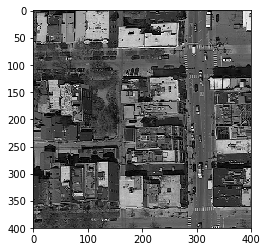

In [89]:
plt.imshow(imgs[0][:,:], cmap='gray')

In [33]:
#plt.imshow(gt_imgs[0][:])

In [95]:
train_X = np.stack( imgs[0:80], axis=0 ).reshape(-1,400,400,1)
train_Y = np.stack( gt_imgs[0:80], axis=0 )
test_X = np.stack( imgs[80:100], axis=0 ).reshape(-1,400,400,1)
test_Y = np.stack( gt_imgs[80:100], axis=0 )
train_X.shape, test_Y.shape

((80, 400, 400, 1), (20, 400, 400))

In [96]:
train_X = train_X.astype('float32')/255
test_X = test_X.astype('float32')/255

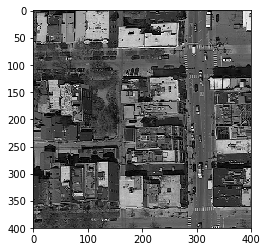

In [102]:
plt.imshow(train_X[0,:,:,0], cmap="gray")

In [103]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

In [104]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((64, 400, 400, 1), (16, 400, 400, 1), (64, 400, 400), (16, 400, 400))

In [105]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU